In [20]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from matplotlib import font_manager, rc
# import warnings
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from sklearn.model_selection import StratifiedKFold
# import lightgbm as lgb
# from sklearn.metrics import f1_score, confusion_matrix
# import math

# # 경고 메시지 무시
# warnings.filterwarnings('ignore')

# # 한글 폰트 설정
# font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
# fontprop = font_manager.FontProperties(fname=font_path)
# rc('font', family=fontprop.get_name())

# # 1. 데이터 로드
# train = pd.read_csv('/apps/study_promptengineerings/dacon/real_estate_fraud/train.csv')
# test = pd.read_csv('/apps/study_promptengineerings/dacon/real_estate_fraud/test.csv')

# # ID 매핑 저장 및 컬럼 제거
# id_mapping = pd.Series(test['ID'].values, index=test.index)
# train = train.drop('ID', axis=1)
# test = test.drop('ID', axis=1)

# import pandas as pd

# # 1️⃣ ID 컬럼 제거
# if 'ID' in train.columns:
#     train = train.drop('ID', axis=1)
# if 'ID' in test.columns:
#     test = test.drop('ID', axis=1)

# # 2️⃣ 결측치 처리
# # 2.1 총층 처리
# train['총층'] = train['총층'].fillna(train['총층'].median())
# test['총층'] = test['총층'].fillna(test['총층'].median())

# # 2.2 욕실수 처리
# train['욕실수'] = train['욕실수'].fillna(train.groupby('방수')['욕실수'].transform('median'))
# test['욕실수'] = test['욕실수'].fillna(test.groupby('방수')['욕실수'].transform('median'))
# train['욕실수'] = train['욕실수'].fillna(train['욕실수'].median())
# test['욕실수'] = test['욕실수'].fillna(test['욕실수'].median())

# # 2.3 해당층 처리
# train['해당층'] = train['해당층'].fillna(train['해당층'].median())
# test['해당층'] = test['해당층'].fillna(test['해당층'].median())

# # 2.4 전용면적 처리
# train['전용면적'] = train['전용면적'].fillna(train.groupby(['방수', '욕실수'])['전용면적'].transform('median'))
# test['전용면적'] = test['전용면적'].fillna(test.groupby(['방수', '욕실수'])['전용면적'].transform('median'))
# train['전용면적'] = train['전용면적'].fillna(train['전용면적'].median())
# test['전용면적'] = test['전용면적'].fillna(test['전용면적'].median())

# # 2.5 총주차대수 처리
# train.loc[train['주차가능여부'] == '불가능', '총주차대수'] = train.loc[train['주차가능여부'] == '불가능', '총주차대수'].fillna(0)
# test.loc[test['주차가능여부'] == '불가능', '총주차대수'] = test.loc[test['주차가능여부'] == '불가능', '총주차대수'].fillna(0)

# train.loc[train['주차가능여부'] == '가능', '총주차대수'] = train.loc[train['주차가능여부'] == '가능', '총주차대수'].fillna(
#     train.loc[train['주차가능여부'] == '가능', '총주차대수'].median())
# test.loc[test['주차가능여부'] == '가능', '총주차대수'] = test.loc[test['주차가능여부'] == '가능', '총주차대수'].fillna(
#     test.loc[test['주차가능여부'] == '가능', '총주차대수'].median())

# # 2.6 방수 처리
# train['방수'] = train['방수'].fillna(train.groupby('중개사무소')['방수'].transform('mean'))
# test['방수'] = test['방수'].fillna(test.groupby('중개사무소')['방수'].transform('mean'))

# train['방수'] = train['방수'].fillna(train['방수'].mean())
# test['방수'] = test['방수'].fillna(test['방수'].mean())

# # 3️⃣ 게재일 변환
# train["게재일"] = pd.to_datetime(train["게재일"], errors="coerce")
# test["게재일"] = pd.to_datetime(test["게재일"], errors="coerce")

# # 결측치 처리: NaT를 최소값으로 대체
# train["게재일"] = train["게재일"].fillna(train["게재일"].min())
# test["게재일"] = test["게재일"].fillna(test["게재일"].min())

# # 기준 날짜 설정
# min_date_train = train["게재일"].min()
# min_date_test = test["게재일"].min()

# # 주차 계산
# train["게재일_변환"] = ((train["게재일"] - min_date_train).dt.days // 30).clip(lower=0)
# test["게재일_변환"] = ((test["게재일"] - min_date_test).dt.days // 30).clip(lower=0)

# # 변환된 값으로 대체 및 컬럼 삭제
# train["게재일"] = train["게재일_변환"]
# test["게재일"] = test["게재일_변환"]

# if "게재일_변환" in train.columns:
#     train.drop(columns=["게재일_변환"], inplace=True)
# if "게재일_변환" in test.columns:
#     test.drop(columns=["게재일_변환"], inplace=True)

# # 결측치 확인
# print("Train set missing values:")
# print(train.isnull().sum())
# print("\nTest set missing values:")
# print(test.isnull().sum())

# # 3. 피처 인코딩
# # 3.1 레이블 인코딩
# label_cols = ['중개사무소', '게재일']
# for col in label_cols:
#     le = LabelEncoder()
#     combined_data = pd.concat([train[col], test[col]], axis=0).astype(str)
#     le.fit(combined_data)
#     train[col] = le.transform(train[col].astype(str))
#     test[col] = le.transform(test[col].astype(str))

# # 3.2 원-핫 인코딩
# onehot_cols = ['매물확인방식', '방향', '주차가능여부', '제공플랫폼']
# onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

# # 피처 이름 생성
# feature_names = []
# for col in onehot_cols:
#     unique_vals = pd.concat([train[col], test[col]]).unique()
#     feature_names.extend([f"{col}_{val}" for val in unique_vals])

# # 인코딩 적용
# train_encoded = onehot.fit_transform(train[onehot_cols])
# test_encoded = onehot.transform(test[onehot_cols])

# # 데이터프레임 결합
# train = pd.concat([
#     train.drop(columns=onehot_cols),
#     pd.DataFrame(train_encoded, index=train.index, columns=feature_names)
# ], axis=1)

# test = pd.concat([
#     test.drop(columns=onehot_cols),
#     pd.DataFrame(test_encoded, index=test.index, columns=feature_names)
# ], axis=1)

# # 4. 데이터 준비
# X = train.drop('허위매물여부', axis=1)
# y = train['허위매물여부']

# # 클래스 가중치 계산
# class_weights = dict(zip(
#     np.unique(y),
#     1 / np.bincount(y) * len(y) / 2
# ))

# # 5. 모델 학습 및 예측
# params = {
#     'objective': 'binary',
#     'boosting_type': 'gbdt',
#     'num_leaves': 25,
#     'learning_rate': 0.05,
#     'seed': 42,
#     'metric': 'binary_logloss',
#     'n_estimators': 1000,
#     'subsample': 0.8,
#     'colsample_bytree': 0.9,
#     'reg_alpha': 0.1,
#     'reg_lambda': 0.1,
#     'min_child_samples': 5,
#     'scale_pos_weight': class_weights[1]/class_weights[0]  # 클래스 불균형 처리
# } 

# # 교차 검증 설정
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# oof_preds = np.zeros(len(X))
# test_preds = np.zeros(len(test))

# # 모델 학습
# for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
#     print(f"Training fold {fold + 1}/5")
    
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
#     train_data = lgb.Dataset(X_train, label=y_train)
#     val_data = lgb.Dataset(X_val, label=y_val)
    
#     model = lgb.train(
#         params,
#         train_data,
#         valid_sets=[val_data],
#         num_boost_round=1000,
#         callbacks=[
#             lgb.early_stopping(stopping_rounds=50),
#             lgb.log_evaluation(period=100)
#         ]
#     )
    
#     oof_preds[val_idx] = model.predict(X_val)
#     test_preds += model.predict(test) / skf.n_splits

# # 6. 모델 평가
# oof_preds_binary = (oof_preds > 0.5).astype(int)
# f1 = f1_score(y, oof_preds_binary, average='macro')
# print(f"\nOOF F1 Score: {f1:.4f}")

# # 혼동 행렬 시각화
# plt.figure(figsize=(8, 6))
# cm = confusion_matrix(y, oof_preds_binary)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()

# # 7. 제출 파일 생성
# test_preds_binary = (test_preds > 0.5).astype(int)
# submission = pd.DataFrame({
#     'ID': id_mapping,
#     '허위매물여부': test_preds_binary
# })
# submission.to_csv('submission.csv', index=False)
# print("Submission file has been created successfully!")

# # 8. 특성 중요도 시각화
# feature_importance = pd.DataFrame({
#     'feature': X.columns,
#     'importance': model.feature_importance()
# })
# feature_importance = feature_importance.sort_values('importance', ascending=False)

# plt.figure(figsize=(10, 6))
# sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
# plt.title('Top 15 Feature Importance')
# plt.show()

Training fold 1/5
[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 1961, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121367 -> initscore=-1.979552
[LightGBM] [Info] Start training from score -1.979552
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.091626
[200]	valid_0's binary_logloss: 0.0821925
Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.0821925
Training fold 2/5
[LightGBM] [Info] Number of positive: 238, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

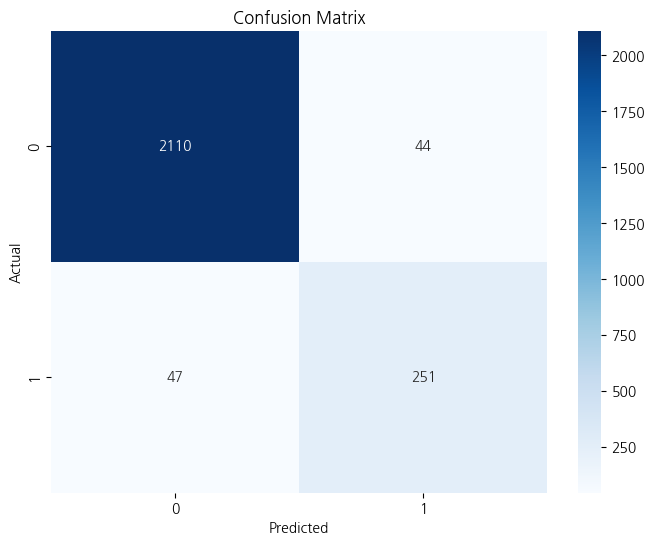

Submission file has been created successfully!


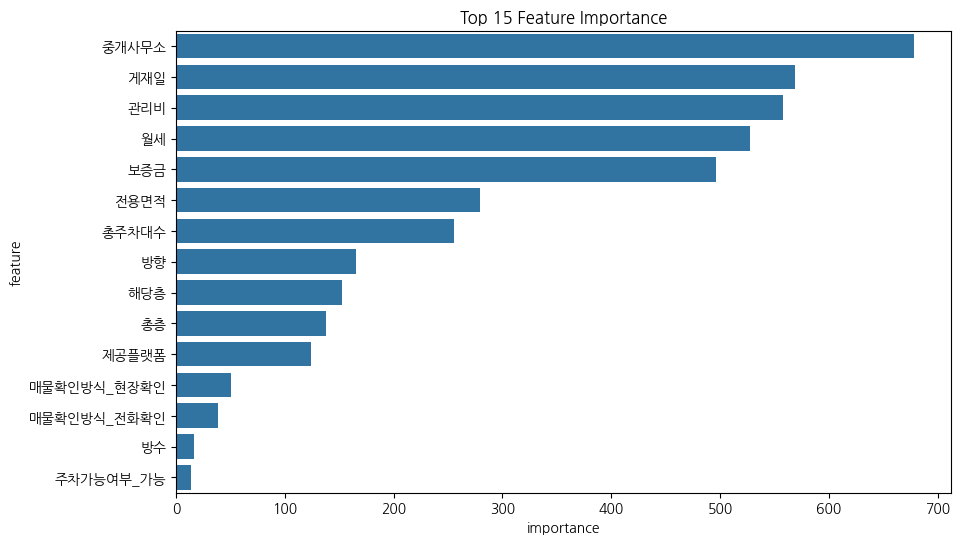

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import f1_score, confusion_matrix
import math

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 한글 폰트 설정
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = font_manager.FontProperties(fname=font_path)
rc('font', family=fontprop.get_name())

# 1. 데이터 로드
train = pd.read_csv('/apps/study_promptengineerings/dacon/real_estate_fraud/train.csv')
test = pd.read_csv('/apps/study_promptengineerings/dacon/real_estate_fraud/test.csv')

# ID 매핑 저장 및 컬럼 제거
id_mapping = pd.Series(test['ID'].values, index=test.index)
train = train.drop('ID', axis=1)
test = test.drop('ID', axis=1)

# 2. 결측치 처리
# 2.1 총층 처리
train['총층'] = train['총층'].fillna(train['총층'].median())
test['총층'] = test['총층'].fillna(test['총층'].median())

# 2.2 욕실수 처리
train['욕실수'] = train['욕실수'].fillna(train.groupby('방수')['욕실수'].transform('median'))
test['욕실수'] = test['욕실수'].fillna(test.groupby('방수')['욕실수'].transform('median'))
train['욕실수'] = train['욕실수'].fillna(train['욕실수'].median())
test['욕실수'] = test['욕실수'].fillna(test['욕실수'].median())

# 2.3 해당층 처리
train['해당층'] = train['해당층'].fillna(train['해당층'].median())
test['해당층'] = test['해당층'].fillna(test['해당층'].median())

# 2.4 전용면적 처리
train['전용면적'] = train['전용면적'].fillna(train.groupby(['방수', '욕실수'])['전용면적'].transform('median'))
test['전용면적'] = test['전용면적'].fillna(test.groupby(['방수', '욕실수'])['전용면적'].transform('median'))
train['전용면적'] = train['전용면적'].fillna(train['전용면적'].median())
test['전용면적'] = test['전용면적'].fillna(test['전용면적'].median())

# 2.5 총주차대수 처리
train.loc[train['주차가능여부'] == '불가능', '총주차대수'] = 0
test.loc[test['주차가능여부'] == '불가능', '총주차대수'] = 0

train.loc[train['주차가능여부'] == '가능', '총주차대수'] = train.loc[train['주차가능여부'] == '가능', '총주차대수'].fillna(
    train.loc[train['주차가능여부'] == '가능', '총주차대수'].median())
test.loc[test['주차가능여부'] == '가능', '총주차대수'] = test.loc[test['주차가능여부'] == '가능', '총주차대수'].fillna(
    test.loc[test['주차가능여부'] == '가능', '총주차대수'].median())

# 2.6 방수 처리
train['방수'] = train['방수'].fillna(train.groupby('중개사무소')['방수'].transform('mean'))
test['방수'] = test['방수'].fillna(test.groupby('중개사무소')['방수'].transform('mean'))

train['방수'] = train['방수'].fillna(train['방수'].mean())
test['방수'] = test['방수'].fillna(test['방수'].mean())

# 3. 게재일 변환
train["게재일"] = pd.to_datetime(train["게재일"], errors="coerce")
test["게재일"] = pd.to_datetime(test["게재일"], errors="coerce")

# 결측치 처리: NaT를 최소값으로 대체
train["게재일"] = train["게재일"].fillna(train["게재일"].min())
test["게재일"] = test["게재일"].fillna(test["게재일"].min())

# 기준 날짜 설정
min_date_train = train["게재일"].min()
min_date_test = test["게재일"].min()

# 주차 계산
train["게재일"] = ((train["게재일"] - min_date_train).dt.days // 30).clip(lower=0)
test["게재일"] = ((test["게재일"] - min_date_test).dt.days // 30).clip(lower=0)

# 4. 피처 인코딩
# 4.1 레이블 인코딩
label_cols = ['중개사무소', '게재일', '제공플랫폼', '방향']
for col in label_cols:
    le = LabelEncoder()
    combined_data = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined_data)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

# 4.2 원-핫 인코딩
onehot_cols = ['매물확인방식', '주차가능여부']
onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')

# train과 test를 결합하여 인코딩
combined = pd.concat([train[onehot_cols], test[onehot_cols]], axis=0)
onehot.fit(combined)

# 인코딩 적용
train_encoded = onehot.transform(train[onehot_cols])
test_encoded = onehot.transform(test[onehot_cols])

# 새로운 피처 이름 생성
feature_names = onehot.get_feature_names_out(onehot_cols)

# 데이터프레임 결합
train = pd.concat([
    train.drop(columns=onehot_cols),
    pd.DataFrame(train_encoded, index=train.index, columns=feature_names)
], axis=1)

test = pd.concat([
    test.drop(columns=onehot_cols),
    pd.DataFrame(test_encoded, index=test.index, columns=feature_names)
], axis=1)

# 5. 데이터 준비
X = train.drop('허위매물여부', axis=1)
y = train['허위매물여부']

# 클래스 가중치 계산
class_weights = dict(zip(
    np.unique(y),
    1 / np.bincount(y) * len(y) / 2
))

# 6. 모델 학습 및 예측
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 25,
    'learning_rate': 0.05,
    'seed': 42,
    'metric': 'binary_logloss',
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'min_child_samples': 5,
    'scale_pos_weight': class_weights[1]/class_weights[0]  # 클래스 불균형 처리
} 

# 교차 검증 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(test))

# 모델 학습
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Training fold {fold + 1}/5")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )
    
    oof_preds[val_idx] = model.predict(X_val)
    test_preds += model.predict(test) / skf.n_splits

# 7. 모델 평가
oof_preds_binary = (oof_preds > 0.5).astype(int)
f1 = f1_score(y, oof_preds_binary, average='macro')
print(f"\nOOF F1 Score: {f1:.4f}")

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, oof_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 8. 제출 파일 생성
test_preds_binary = (test_preds > 0.5).astype(int)
submission = pd.DataFrame({
    'ID': id_mapping,
    '허위매물여부': test_preds_binary
})
submission.to_csv('submission.csv', index=False)
print("Submission file has been created successfully!")

# 9. 특성 중요도 시각화
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importance()
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance')
plt.show()
